In [24]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy import stats
from scipy import integrate
from IPython.display import HTML, display
from scipy.stats import norm
from scipy.stats import t as the
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 70)

import warnings
warnings.filterwarnings("ignore")

In [25]:
# Define a list of file paths for the subject data files
# list_of_files = ['PAMAP2_Dataset/Protocol/subject101.dat',
#                  'PAMAP2_Dataset/Protocol/subject102.dat',
#                  'PAMAP2_Dataset/Protocol/subject103.dat',
#                  'PAMAP2_Dataset/Protocol/subject104.dat',
#                  'PAMAP2_Dataset/Protocol/subject105.dat',
#                  'PAMAP2_Dataset/Protocol/subject106.dat',
#                  'PAMAP2_Dataset/Protocol/subject107.dat',
#                  'PAMAP2_Dataset/Protocol/subject108.dat',
#                  'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityID = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

# Protocol Activities: lie, sit, stand, walk, run, cycle, Nordic walk, ascend and descend stairs, vacuum cleaning, ironing, and rope jump
protocol_acts = [1,2,3,4,5,6,7,12,13,16,17,24]

# Optional Activities: watching TV, computer work, car driving, folding laundry, house cleaning, playing soccer
optional_acts = [9,10,11,18,19,20]

# MET Classification of activities
# lying, sitting, standing and ironing
light_acts = [1,2,3,17]
# vacuum cleaning, descending stairs, walking, Nordic walking and cycling
mod_acts = [16,13,4,7,6]
# ascending stairs, running and rope jumping
vig_acts = [12,5,24]

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2',
           'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
            'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
            'chestGyro1', 'chestGyro2', 'chestGyro3',
            'chestMagne1', 'chestMagne2', 'chestMagne3',
            'chestOrientation1', 'chestOrientation2',
            'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
            'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
            'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
            'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
            'ankleOrientation1', 'ankleOrientation2',
            'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  # all columns in one list

In [26]:
fields = [
    "timestamp",
    "activityID",
    "handAcc16_1",
    "handAcc16_2",
    "handAcc16_3",
    "handGyro1",
    "handGyro2",
    "handGyro3",
    "chestAcc16_1",
    "chestAcc16_2",
    "chestAcc16_3",
    "chestGyro1",
    "chestGyro2",
    "chestGyro3",
    "ankleAcc16_1",
    "ankleAcc16_2",
    "ankleAcc16_3",
    "ankleGyro1",
    "ankleGyro2",
    "ankleGyro3",
]

In [27]:
# Define a function to extract the features and labels from the subject data file
def load_data(file_path):
    frames = []
    # Read the subject data file into a pandas DataFrame
    for file in tqdm(os.listdir(file_path)):
        if file.endswith(".dat"):
            # Feed all column names to dataframe reader so that we can select only activityID and the accelerometer and gyroscope data
            input_data = pd.read_table(
                os.path.join(file_path, file), names=columns, usecols=fields, header=None, sep="\s+"
            )
            subject_id = int(file[-5])
            input_data.insert(0, 'subjectID', subject_id) # prepend subject_id column from filename

            # Keep only protocol activities
            input_data = input_data[input_data['activityID'].isin(protocol_acts)]
            input_data['activityID'] = input_data['activityID'].astype(int)

            frames.append(input_data)

    sensor_data = pd.concat(frames, ignore_index=True)
    sensor_data.reset_index(drop=True, inplace=True)
    print(sensor_data.shape)

    return sensor_data

sensor_data = load_data("PAMAP2_Dataset/Protocol/")
sensor_data.head(100)

100%|██████████| 9/9 [00:08<00:00,  1.03it/s]


(1942872, 21)


,subjectID,timestamp,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handGyro1,handGyro2,handGyro3,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestGyro1,chestGyro2,chestGyro3,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleGyro1,ankleGyro2,ankleGyro3
0,8,67.36,1,-9.64938,-1.68584,0.978888,-0.008240,-2.900350e-02,0.002536,-0.127523,9.77587,0.124375,-0.025464,0.021596,-0.028624,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427
1,8,67.37,1,-9.80348,-1.72328,0.899731,0.054293,-1.860920e-03,-0.023345,0.103751,9.88863,0.205640,-0.007304,-0.024370,-0.024793,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885
2,8,67.38,1,-9.65232,-1.53509,0.862873,0.000324,-4.250060e-02,-0.037061,-0.016212,9.92535,0.009742,0.033524,0.000221,-0.020955,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795
3,8,67.39,1,-9.65045,-1.64823,0.940257,0.009701,-1.265990e-02,0.007476,-0.053382,9.85042,0.048034,-0.030523,-0.034505,-0.014313,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015
4,8,67.40,1,-9.54564,-1.53764,0.672043,-0.026993,-3.300230e-03,0.006464,-0.043287,9.77744,0.396942,-0.022374,-0.035840,-0.026457,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670
5,8,67.41,1,-9.50544,-1.57520,0.749746,-0.010863,-8.358160e-03,-0.005187,-0.099503,9.84872,-0.223843,-0.020686,0.000852,-0.017788,9.67153,-0.116859,-2.57895,0.004332,-0.009173,-0.006735
6,8,67.42,1,-9.53762,-1.53563,0.903080,-0.047887,5.507200e-03,0.005639,-0.054327,9.92546,0.009052,-0.008714,-0.027601,0.007657,9.55606,-0.305348,-2.65615,-0.002965,-0.025048,0.003337
7,8,67.43,1,-9.73084,-1.76247,0.823976,-0.032073,-5.739650e-03,0.012168,-0.018898,9.77421,-0.067257,-0.045058,-0.022100,-0.020095,9.52183,-0.115910,-2.58049,-0.025889,0.030230,0.004583
8,8,67.44,1,-9.72923,-1.72420,0.862359,0.000533,-3.844910e-02,-0.011859,-0.018500,9.92483,-0.067739,-0.045201,-0.039469,-0.048325,9.63391,-0.154590,-2.57910,-0.036990,0.003719,-0.003572
9,8,67.45,1,-9.57380,-1.68642,0.980022,0.037642,-2.922340e-02,-0.004392,-0.012035,9.77577,0.165188,0.002295,0.002443,-0.013700,9.59479,-0.267938,-2.61739,-0.027711,-0.025120,-0.009332


As a fist cleanup step, the activity ID 0, which corresponds to a transient period between activities is removed from the dataframe.

The next step is keeping only the activities that correspond to each subject as documented. This is to avoid any unexpected or invalid activity data from affecting results.

The data is then linearly interpolated to account for missing data in some rows, such as the HR column.

In [28]:
drop_index = []

# Keep only activities as documented on file "PerformedActivitiesSummary.pdf"
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 1)
        & (sensor_data["activityID"].isin([10, 20]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 2)
        & (sensor_data["activityID"].isin([9, 10, 11, 18, 19, 20]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 3)
        & (sensor_data["activityID"].isin([5, 6, 7, 9, 10, 11, 18, 19, 20, 24]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 4)
        & (sensor_data["activityID"].isin([5, 9, 10, 11, 18, 19, 20, 24]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 5)
        & (sensor_data["activityID"].isin([9, 11, 18, 20]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 6)
        & (sensor_data["activityID"].isin([9, 11, 20]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 7)
        & (sensor_data["activityID"].isin([9, 10, 11, 18, 19, 20, 24]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 8)
        & (sensor_data["activityID"].isin([9, 11]))
    ]
)
drop_index += list(
    sensor_data.index[
        (sensor_data["subjectID"] == 9)
        & (
            sensor_data["activityID"].isin(
                [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 17]
            )
        )
    ]
)

print(len(drop_index))

# Getting indexes of activity 0
drop_index += list(sensor_data.index[sensor_data["activityID"] == 0])

sensor_data = sensor_data.drop(drop_index)
# Interpolate data
sensor_data = sensor_data.interpolate()
print('Observe the removal of miss-classified activities and transient activities with ID zero: %i items' % (len(drop_index)))
print(sensor_data.shape)
sensor_data.head()

1
Observe the removal of miss-classified activities and transient activities with ID zero: 1 items
(1942871, 21)


,subjectID,timestamp,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handGyro1,handGyro2,handGyro3,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestGyro1,chestGyro2,chestGyro3,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleGyro1,ankleGyro2,ankleGyro3
0,8,67.36,1,-9.64938,-1.68584,0.978888,-0.008240,-0.029004,0.002536,-0.127523,9.77587,0.124375,-0.025464,0.021596,-0.028624,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427
1,8,67.37,1,-9.80348,-1.72328,0.899731,0.054293,-0.001861,-0.023345,0.103751,9.88863,0.205640,-0.007304,-0.024370,-0.024793,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885
2,8,67.38,1,-9.65232,-1.53509,0.862873,0.000324,-0.042501,-0.037061,-0.016212,9.92535,0.009742,0.033524,0.000221,-0.020955,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795
3,8,67.39,1,-9.65045,-1.64823,0.940257,0.009701,-0.012660,0.007476,-0.053382,9.85042,0.048034,-0.030523,-0.034505,-0.014313,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015
4,8,67.40,1,-9.54564,-1.53764,0.672043,-0.026993,-0.003300,0.006464,-0.043287,9.77744,0.396942,-0.022374,-0.035840,-0.026457,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670


<Figure size 1000x600 with 0 Axes>

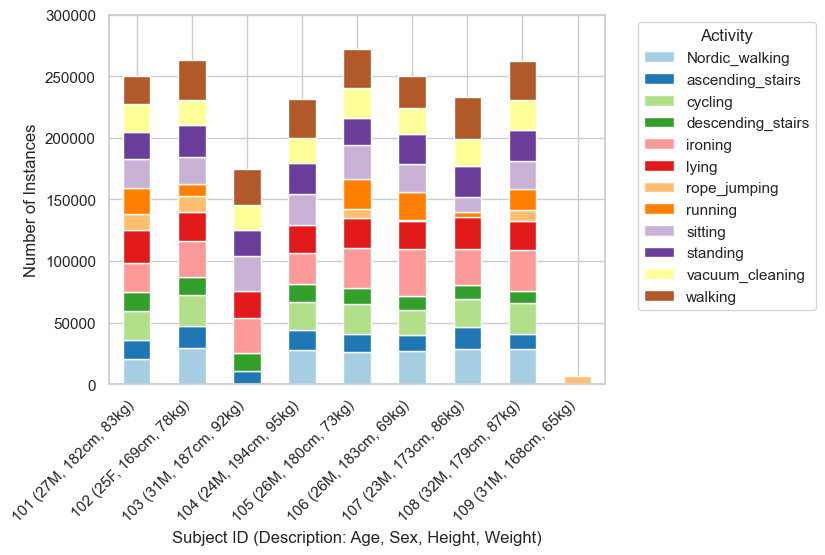

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Customize the x-axis labels
subject_labels = [
    '101 (27M, 182cm, 83kg)',
    '102 (25F, 169cm, 78kg)',
    '103 (31M, 187cm, 92kg)',
    '104 (24M, 194cm, 95kg)',
    '105 (26M, 180cm, 73kg)',
    '106 (26M, 183cm, 69kg)',
    '107 (23M, 173cm, 86kg)',
    '108 (32M, 179cm, 87kg)',
    '109 (31M, 168cm, 65kg)'
]

# Compute the cross-tabulation of 'subjectID' and 'activity' without modifying sensor_data
subject_counts = sensor_data.groupby(['subjectID', sensor_data['activityID'].replace(activityID)]).size().unstack(fill_value=0)

# Rename the index and columns for better readability, adding '10' to the subjectIDs using a lambda function
subject_counts = subject_counts.rename(index=lambda x: '10' + str(x))

# Rename the index and columns for better readability
subject_counts.index.name = 'subject'
subject_counts.columns.name = 'activity'

# print(subject_counts.head(10))

# Define a custom color palette using hexadecimal color codes
custom_palette = ['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
                  '#cab2d6', '#6a3d9a', '#ffff99', '#b15928']

# Create the stacked bar plot using Seaborn
sns.set(style='whitegrid', palette=custom_palette)
plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar', stacked=True)
plt.xlabel('Subject ID (Description: Age, Sex, Height, Weight)')
plt.ylabel('Number of Instances')
# plt.title('Activity Distribution by Subject')
plt.legend(title='Activity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')  # Keep 45-degree rotation and horizontal alignment
plt.xticks(range(len(subject_labels)), subject_labels)  # Use subject_labels as x-axis labels
# Set the y-axis limits to include 30,000
plt.ylim(0, 300000)
plt.show()

<Figure size 1000x600 with 0 Axes>

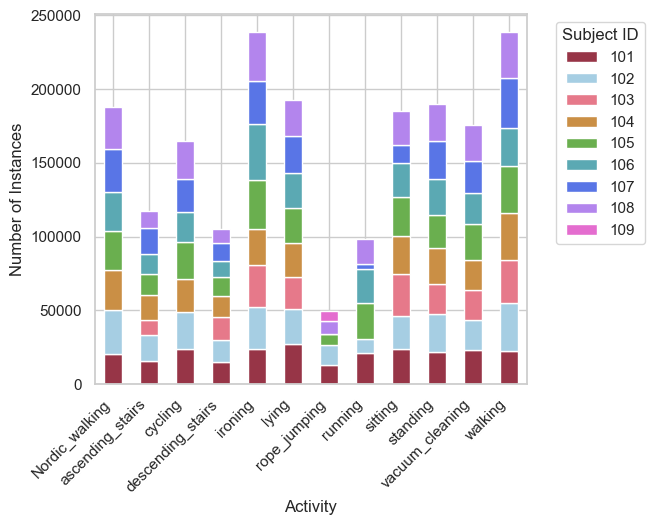

In [30]:
# Compute the cross-tabulation of 'activity' and 'subjectID' without modifying sensor_data
activity_counts = sensor_data.groupby([sensor_data['activityID'].replace(activityID), 'subjectID']).size().unstack(fill_value=0).rename(columns=lambda x: '10' + str(x))

# # Rename the index and columns for better readability
activity_counts.index.name = 'activity'
activity_counts.columns.name = 'subject'

# print(activity_counts.head(10))

# Define a custom color palette using hexadecimal color codes
custom_palette = ['#973547', '#a6cee3', '#e6798a', '#ca8f45', '#6aaf4f', '#5ba9b3', '#5975e6', '#b385ed', '#e46dcf']

# Create the stacked bar plot using Seaborn
sns.set(style='whitegrid', palette=custom_palette)
plt.figure(figsize=(10, 6))
ax = activity_counts.plot(kind='bar', stacked=True)
plt.xlabel('Activity')
plt.ylabel('Number of Instances')
# plt.title('Subject Distribution by Activity')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.8)  # Adjust the figure size to accommodate the legend
plt.show()

In [31]:
# Latest Code

In [32]:
sensor_data.columns

Index(['subjectID', 'timestamp', 'activityID', 'handAcc16_1', 'handAcc16_2',
       'handAcc16_3', 'handGyro1', 'handGyro2', 'handGyro3', 'chestAcc16_1',
       'chestAcc16_2', 'chestAcc16_3', 'chestGyro1', 'chestGyro2',
       'chestGyro3', 'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
       'ankleGyro1', 'ankleGyro2', 'ankleGyro3'],
      dtype='object')

In [33]:
sensor_data.head(10)

,subjectID,timestamp,activityID,handAcc16_1,handAcc16_2,handAcc16_3,handGyro1,handGyro2,handGyro3,chestAcc16_1,chestAcc16_2,chestAcc16_3,chestGyro1,chestGyro2,chestGyro3,ankleAcc16_1,ankleAcc16_2,ankleAcc16_3,ankleGyro1,ankleGyro2,ankleGyro3
0,8,67.36,1,-9.64938,-1.68584,0.978888,-0.008240,-0.029004,0.002536,-0.127523,9.77587,0.124375,-0.025464,0.021596,-0.028624,9.56066,-0.268664,-2.50197,-0.009174,-0.058976,0.001427
1,8,67.37,1,-9.80348,-1.72328,0.899731,0.054293,-0.001861,-0.023345,0.103751,9.88863,0.205640,-0.007304,-0.024370,-0.024793,9.55465,-0.152831,-2.73429,-0.018588,0.020064,-0.008885
2,8,67.38,1,-9.65232,-1.53509,0.862873,0.000324,-0.042501,-0.037061,-0.016212,9.92535,0.009742,0.033524,0.000221,-0.020955,9.63151,-0.191916,-2.65608,0.023151,0.020882,-0.019795
3,8,67.39,1,-9.65045,-1.64823,0.940257,0.009701,-0.012660,0.007476,-0.053382,9.85042,0.048034,-0.030523,-0.034505,-0.014313,9.55866,-0.230053,-2.57941,-0.009122,-0.003075,-0.013015
4,8,67.40,1,-9.54564,-1.53764,0.672043,-0.026993,-0.003300,0.006464,-0.043287,9.77744,0.396942,-0.022374,-0.035840,-0.026457,9.55846,-0.268022,-2.57917,0.013797,-0.009872,0.032670
5,8,67.41,1,-9.50544,-1.57520,0.749746,-0.010863,-0.008358,-0.005187,-0.099503,9.84872,-0.223843,-0.020686,0.000852,-0.017788,9.67153,-0.116859,-2.57895,0.004332,-0.009173,-0.006735
6,8,67.42,1,-9.53762,-1.53563,0.903080,-0.047887,0.005507,0.005639,-0.054327,9.92546,0.009052,-0.008714,-0.027601,0.007657,9.55606,-0.305348,-2.65615,-0.002965,-0.025048,0.003337
7,8,67.43,1,-9.73084,-1.76247,0.823976,-0.032073,-0.005740,0.012168,-0.018898,9.77421,-0.067257,-0.045058,-0.022100,-0.020095,9.52183,-0.115910,-2.58049,-0.025889,0.030230,0.004583
8,8,67.44,1,-9.72923,-1.72420,0.862359,0.000533,-0.038449,-0.011859,-0.018500,9.92483,-0.067739,-0.045201,-0.039469,-0.048325,9.63391,-0.154590,-2.57910,-0.036990,0.003719,-0.003572
9,8,67.45,1,-9.57380,-1.68642,0.980022,0.037642,-0.029223,-0.004392,-0.012035,9.77577,0.165188,0.002295,0.002443,-0.013700,9.59479,-0.267938,-2.61739,-0.027711,-0.025120,-0.009332


In [34]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data(sensor_data, window_size, stride):
    features = sensor_data[['handAcc16_1', 'handAcc16_2', 'handAcc16_3',
                            'handGyro1', 'handGyro2', 'handGyro3',
                            'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
                            'chestGyro1', 'chestGyro2', 'chestGyro3',
                            'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
                            'ankleGyro1', 'ankleGyro2', 'ankleGyro3']].values

    windows = []
    subjects = []
    activities = []
    windowed_samples = 0
    discarded_samples = 0

    majority_threshold = 0.50  # Set the majority threshold

    num_samples = len(sensor_data)

    for i in range(0, num_samples - window_size + 1, stride):
        window = features[i:i + window_size]

        if len(window) == window_size:
            activity_counts = sensor_data.iloc[i:i + window_size]['activityID'].value_counts()
            subject_counts = sensor_data.iloc[i:i + window_size]['subjectID'].value_counts()
            majority_activity = activity_counts.idxmax()
            majority_subject = subject_counts.idxmax()
            majority_activity_percentage = activity_counts.max() / window_size

            if majority_activity_percentage > majority_threshold:
                windows.append(window)
                subjects.append(majority_subject)
                activities.append(majority_activity)
                windowed_samples += len(window)
            else:
                discarded_samples += len(window)
                print(majority_activity_percentage)

    # Convert lists to numpy arrays
    windows = np.array(windows)
    subjects = np.array(subjects)
    activities = np.array(activities)

    # # Encode activity and subject labels
    # label_encoder = LabelEncoder()
    # activities = label_encoder.fit_transform(activities)
    # subjects = label_encoder.fit_transform(subjects)

    return windows, subjects, activities, windowed_samples, discarded_samples

# Step 1: Read the data and windowing
window_size = 100
stride = 50

windows, subjects, activities, windowed_samples, discarded_samples = prepare_data(sensor_data, window_size, stride)

print("Number of samples in windowed dataset:", windowed_samples)
print("Number of discarded window samples:", discarded_samples)
print(windows.shape)

0.5
0.5
0.5
Number of samples in windowed dataset: 3885300
Number of discarded window samples: 300
(38853, 100, 18)


In [35]:
# Flatten the windows array
flattened_windows = windows.reshape(-1, windows.shape[-1])

# Use np.unique to get the unique rows and their counts
unique_rows, counts = np.unique(flattened_windows, axis=0, return_counts=True)

# Calculate the number of unique instances in sensor_data that occurs in all the windows
num_unique_instances = len(unique_rows)

# # Flatten the windows array and reshape it to have 21 columns
# flattened_windows = windows.reshape(-1, windows.shape[-1])
#
# # Get the indices of the unique rows in flattened_windows
# unique_indices = np.unique(flattened_windows, axis=0, return_index=True)[1]
#
# # Extract the unique instances from sensor_data based on the unique indices
# unique_instances = sensor_data.iloc[unique_indices]
#
# # Calculate the number of unique instances from sensor_data that are used in the windows
# num_unique_instances = len(unique_instances)
#
# print("Number of unique instances in sensor_data that are used in the windows:", num_unique_instances)


# Because of the stride this can be different from the number of discarded samples.
print("Number of unique sensor_data entries that are used in windows without being discarded:", num_unique_instances)
print("Number of original raw samples from sensor_data:", len(sensor_data))

# With only 21 unique samples not represented in the windowed data we have a good coverage of the original data.
print("True number of discarded samples:", len(sensor_data) - num_unique_instances)
print("Number of windows:", windows.shape[0])
print(windows.shape)

Number of unique sensor_data entries that are used in windows without being discarded: 1942850
Number of original raw samples from sensor_data: 1942871
True number of discarded samples: 21
Number of windows: 38853
(38853, 100, 18)


In [36]:
def display_window(window, subject, activity, feature_labels):
    for i, feature_label in enumerate(feature_labels):
        print(f"{feature_label}: {window[:, i]}")
    print(f"Subject: {subject}")
    print(f"Activity: {activity}")
    print("\n")

# Display first window
print("First Window:")
display_window(windows[0], subjects[0], activities[0], sensor_data.columns[3:])

# Display middle window
middle_index = len(windows) // 2
print("Middle Window:")
display_window(windows[middle_index], subjects[middle_index], activities[middle_index], sensor_data.columns[3:])

# Display last window
print("Last Window:")
display_window(windows[-1], subjects[-1], activities[-1], sensor_data.columns[3:])


First Window:
handAcc16_1: [-9.64938 -9.80348 -9.65232 -9.65045 -9.54564 -9.50544 -9.53762 -9.73084
 -9.72923 -9.5738  -9.53868 -9.42371 -9.69091 -9.64777 -9.69412 -9.38779
 -9.46658 -9.65392 -9.65419 -9.66462 -9.4623  -9.66087 -9.53788 -9.69037
 -9.69492 -9.53467 -9.61185 -9.61052 -9.68289 -9.61827 -9.57567 -9.57032
 -9.57487 -9.53494 -9.6172  -9.60891 -9.65258 -9.57647 -9.65232 -9.68369
 -9.65178 -9.54002 -9.46043 -9.65553 -9.65366 -9.54002 -9.72977 -9.69171
 -9.57674 -9.65232 -9.46819 -9.61025 -9.6156  -9.53842 -9.5336  -9.57781
 -9.65205 -9.53895 -9.57647 -9.65686 -9.61506 -9.53467 -9.65446 -9.5328
 -9.57621 -9.57861 -9.51159 -9.61399 -9.6164  -9.50384 -9.65499 -9.53414
 -9.5754  -9.50544 -9.50143 -9.61266 -9.61079 -9.61586 -9.61159 -9.42612
 -9.58102 -9.46097 -9.61587 -9.69359 -9.57541 -9.57139 -9.57407 -9.45883
 -9.64858 -9.56952 -9.57808 -9.57674 -9.54644 -9.64644 -9.64965 -9.57541
 -9.61266 -9.57808 -9.65419 -9.57594]
handAcc16_2: [-1.68584 -1.72328 -1.53509 -1.64823 -1.53764 -

In [37]:
# Nested cross-validation method

In [38]:
# from sklearn.model_selection import StratifiedKFold
#
# skf = StratifiedKFold(n_splits=5)
# activity_splits = skf.split(windows, activities)
#
# # Activity Stratification: Start by using StratifiedKFold from sklearn.model_selection. This will ensure that each fold has the same proportion of samples from each activity. You'll first split the dataset into 'k' folds maintaining the same distribution of activities in each fold.

In [39]:
# from sklearn.model_selection import GroupKFold
#
# subject_splits = []
# for train_index, test_index in activity_splits:
#     X_train, X_test = windows[train_index], windows[test_index]
#     y_train, y_test = activities[train_index], activities[test_index]
#     subjects_train, subjects_test = subjects[train_index], subjects[test_index]
#
#     gkf = GroupKFold(n_splits=5)
#     subject_splits.append(gkf.split(X_train, y_train, subjects_train))
#
# # Subject Grouping: For each of the 'k' folds from the first level, you can further split them based on subjects. You can use GroupKFold for this purpose. This will ensure that all samples from the same subject stay in the same fold.

In [40]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
#
# # Create a list to store losses and accuracies
# losses = []
# accuracies = []
#
# num_features = windows.shape[2]
# unique_activities = np.unique(activities)
# num_classes = len(unique_activities)
#
# # For each subject split
# for train_index, val_index in subject_splits:
#     X_train, X_val = windows[train_index], windows[val_index]
#     y_train, y_val = activities[train_index], activities[val_index]
#
#     # Build and compile your LSTM model
#     model = Sequential()
#     model.add(LSTM(100, input_shape=(window_size, num_features)))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
#     # Train the model
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64)
#
#     # Store the loss and accuracy
#     losses.append(history.history['loss'])
#     accuracies.append(history.history['accuracy'])


In [41]:
# # Calculate the average loss and accuracy
# avg_loss = np.mean(losses, axis=0)
# avg_accuracy = np.mean(accuracies, axis=0)

In [42]:
# import numpy as np
# import tensorflow as tf
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold, GroupKFold
# from sklearn.metrics import confusion_matrix
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
# import matplotlib.pyplot as plt
#
# num_features = windows.shape[2]
# unique_activities = np.unique(activities)
# unique_subjects = np.unique(subjects)
# num_classes = len(unique_activities)
#
# epochs = 8
# batch_size = 32
# n_splits = 5
#
# # Re-label activities and subjects to start from zero
# activity_map = {act: i for i, act in enumerate(unique_activities)}
# subject_map = {sub: i for i, sub in enumerate(unique_subjects)}
# activities_relabeled = np.array([activity_map[act] for act in activities])
# subjects_relabeled = np.array([subject_map[sub] for sub in subjects])
#
# # Convert labels to categorical
# activities_categorical = to_categorical(activities_relabeled)
#
# # Initialize the StratifiedKFold object
# skf = StratifiedKFold(n_splits=n_splits)
#
# # Store all histories
# all_histories = []
#
# # Loop over all activity splits
# for activity_train_index, activity_test_index in skf.split(windows, activities_relabeled):
#     # Split the data into training and testing sets
#     X_train, X_test = windows[activity_train_index], windows[activity_test_index]
#     y_train, y_test = activities_categorical[activity_train_index], activities_categorical[activity_test_index]
#     subjects_train, subjects_test = subjects_relabeled[activity_train_index], subjects_relabeled[activity_test_index]
#
#     # Initialize the GroupKFold object
#     gkf = GroupKFold(n_splits=n_splits)
#
#     # Loop over all subject splits
#     for subject_train_index, subject_val_index in gkf.split(X_train, y_train, subjects_train):
#         # Split the data into training and validation sets
#         X_train_subject, X_val = X_train[subject_train_index], X_train[subject_val_index]
#         y_train_subject, y_val = y_train[subject_train_index], y_train[subject_val_index]
#
#         # Define LSTM model
#         model = Sequential()
#         model.add(LSTM(100, input_shape=(window_size, num_features)))
#         model.add(Dense(num_classes, activation='softmax'))
#         model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
#         # Fit the model
#         history = model.fit(X_train_subject, y_train_subject, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size)
#
#         # Append the history to the list of all histories
#         all_histories.append(history)
#
# # Compute the average loss and accuracy over all histories
# avg_loss = np.mean([history.history['loss'] for history in all_histories], axis=0)
# avg_val_loss = np.mean([history.history['val_loss'] for history in all_histories], axis=0)
# avg_accuracy = np.mean([history.history['accuracy'] for history in all_histories], axis=0)
# avg_val_accuracy = np.mean([history.history['val_accuracy'] for history in all_histories], axis=0)
#
# # Plot the average loss and accuracy
# plt.figure(figsize=(12, 6))
#
# plt.subplot(1, 2, 1)
# plt.plot(avg_loss, label='Training Loss')
# plt.plot(avg_val_loss, label='Validation Loss')
# plt.title('Average Loss Over Folds')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
#
# plt.subplot(1, 2, 2)
# plt.plot(avg_accuracy, label='Training Accuracy')
# plt.plot(avg_val_accuracy, label='Validation Accuracy')
# plt.title('Average Accuracy Over Folds')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
#
# plt.tight_layout()
# plt.show()

In [43]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
# from keras.utils import to_categorical
#
# # Re-label activities and subjects to start from zero
# unique_activities = np.unique(activities)
# unique_subjects = np.unique(subjects)
# activity_map = {act: i for i, act in enumerate(unique_activities)}
# subject_map = {sub: i for i, sub in enumerate(unique_subjects)}
# activities_relabeled = np.array([activity_map[act] for act in activities])
# subjects_relabeled = np.array([subject_map[sub] for sub in subjects])
#
# num_features = windows.shape[2]
# num_classes = len(unique_activities)
#
# epochs = 8
# batch_size = 32
#
# # Convert labels to categorical
# activities_categorical = to_categorical(activities_relabeled)
#
# # Split the data into training and testing sets
# train_size = int(0.8 * len(windows))
# X_train, X_test = windows[:train_size], windows[train_size:]
# y_train, y_test = activities_categorical[:train_size], activities_categorical[train_size:]
# subjects_train, subjects_test = subjects_relabeled[:train_size], subjects_relabeled[train_size:]
#
# # Define LSTM model
# model = Sequential()
# model.add(LSTM(100, input_shape=(window_size, num_features)))
# model.add(Dense(num_classes, activation='softmax'))
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
# # Fit the model
# history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
#
# # Plot the loss and accuracy curves
# plt.figure(figsize=(12, 6))
#
# plt.subplot(1, 2, 1)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
#
# plt.subplot(1, 2, 2)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
#
# plt.tight_layout()
# plt.show()
#
# # Evaluate the model on the test set
# loss, accuracy = model.evaluate(X_test, y_test)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)


In [44]:
# This looks like it is not an optimal approach
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


# Re-label activities and subjects to start from zero
unique_activities = np.unique(activities)
unique_subjects = np.unique(subjects)
activity_map = {act: i for i, act in enumerate(unique_activities)}
subject_map = {sub: i for i, sub in enumerate(unique_subjects)}

activities_relabeled = np.array([activity_map[act] for act in activities])
subjects_relabeled = np.array([subject_map[sub] for sub in subjects])

# Create a combined label for stratification
combined_label = subjects_relabeled * len(unique_activities) + activities_relabeled

# StratifiedGroupKFold
n_splits = 5
sgkf = StratifiedGroupKFold(n_splits=n_splits)

train_indices = []
val_indices = []

for train_index, val_index in sgkf.split(windows, combined_label, groups=subjects_relabeled):
    train_indices.append(train_index)
    val_indices.append(val_index)

# The `StratifiedGroupKFold` in the code above attempts to ensure that all activities are represented in both the training and test sets, while each subject group appears in just one of the splits. However, depending on the distribution of activities among the subjects, it might not always be possible to have every activity represented in every split.

# The stratification in `StratifiedGroupKFold` is done based on the `y` parameter, which is `combined_label` in this case. This ensures that the distribution of activities (which is part of the `combined_label`) is similar in each fold.

# The `groups` parameter is set as `subjects_relabeled`. This ensures that all samples with the same group (i.e., subject) are included in the same test set. So, the subjects do not overlap between training and test sets.

# However, this setup does not guarantee that every activity from each subject is represented in both training and test sets. If a certain activity is performed by only one subject and that subject's data is placed in the test set, then the training set will not have any samples of that activity.

# So while this method attempts to balance the distribution of activities and subjects, it's not always perfect, especially when the activities are not evenly distributed among the subjects. For a more controlled split, you might need to implement a custom split logic.

In [45]:
# # This looks like it is not an optimal approach
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Define LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(100, input_shape=input_shape))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

input_shape = (window_size, windows.shape[2])
num_classes = len(unique_activities)

print(input_shape)
print(num_classes)
print(unique_activities)

epochs = 14
batch_size = 32
history_list = []
confusion_matrices = []
f1_scores = []

for i in range(n_splits):
    print(f"Training fold {i + 1}...")
    train_data = windows[train_indices[i]]
    train_labels = to_categorical(activities_relabeled[train_indices[i]], num_classes)
    val_data = windows[val_indices[i]]
    val_labels = to_categorical(activities_relabeled[val_indices[i]], num_classes)

    model = create_lstm_model(input_shape, num_classes)
    history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=epochs, batch_size=batch_size)
    history_list.append(history.history)

    # Confusion matrix
    val_pred = np.argmax(model.predict(val_data), axis=-1)
    cm = confusion_matrix(activities_relabeled[val_indices[i]], val_pred)
    confusion_matrices.append(cm)

(100, 18)
12
[ 1  2  3  4  5  6  7 12 13 16 17 24]
Training fold 1...
Epoch 1/14


2023-05-16 14:35:56.290429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:35:56.389985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:35:56.736368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1044/1044 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.8172

2023-05-16 14:36:30.537009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:36:30.581004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1044/1044 [==============================] - 39s 36ms/step - loss: 0.6694 - accuracy: 0.8172 - val_loss: 0.8094 - val_accuracy: 0.7561
Epoch 2/14
1044/1044 [==============================] - 36s 34ms/step - loss: 0.4042 - accuracy: 0.8917 - val_loss: 0.7763 - val_accuracy: 0.7682
Epoch 3/14
1044/1044 [==============================] - 35s 34ms/step - loss: 0.3295 - accuracy: 0.9074 - val_loss: 0.6601 - val_accuracy: 0.8144
Epoch 4/14
1044/1044 [==============================] - 35s 34ms/step - loss: 0.2867 - accuracy: 0.9185 - val_loss: 0.6478 - val_accuracy: 0.8216
Epoch 5/14
1044/1044 [==============================] - 36s 35ms/step - loss: 0.2571 - accuracy: 0.9252 - val_loss: 0.6712 - val_accuracy: 0.8120
Epoch 6/14
1044/1044 [==============================] - 38s 36ms/step - loss: 0.2384 - accuracy: 0.9300 - val_loss: 0.5973 - val_accuracy: 0.8354
Epoch 7/14
1044/1044 [==============================] - 37s 35ms/step - loss: 0.2184 - accuracy: 0.9352 - val_loss: 0.6222 - val_accura

2023-05-16 14:44:27.265947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:44:27.301199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


171/171 [==============================] - 3s 15ms/step
Training fold 2...
Epoch 1/14


2023-05-16 14:44:31.704229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:44:31.814201: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:44:32.037644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1046/1046 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.8237

2023-05-16 14:45:06.372108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:45:06.414476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1046/1046 [==============================] - 39s 36ms/step - loss: 0.6450 - accuracy: 0.8237 - val_loss: 1.3497 - val_accuracy: 0.6613
Epoch 2/14
1046/1046 [==============================] - 37s 36ms/step - loss: 0.3825 - accuracy: 0.8963 - val_loss: 1.3824 - val_accuracy: 0.6882
Epoch 3/14
1046/1046 [==============================] - 42s 40ms/step - loss: 0.3178 - accuracy: 0.9105 - val_loss: 1.2775 - val_accuracy: 0.6756
Epoch 4/14
1046/1046 [==============================] - 45s 43ms/step - loss: 0.2802 - accuracy: 0.9192 - val_loss: 1.1038 - val_accuracy: 0.6986
Epoch 5/14
1046/1046 [==============================] - 40s 39ms/step - loss: 0.2583 - accuracy: 0.9235 - val_loss: 1.4536 - val_accuracy: 0.6659
Epoch 6/14
1046/1046 [==============================] - 37s 35ms/step - loss: 0.2548 - accuracy: 0.9254 - val_loss: 1.4926 - val_accuracy: 0.6989
Epoch 7/14
1046/1046 [==============================] - 38s 36ms/step - loss: 0.2334 - accuracy: 0.9307 - val_loss: 1.2134 - val_accura

2023-05-16 14:53:27.937447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:53:27.972540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


169/169 [==============================] - 3s 16ms/step
Training fold 3...
Epoch 1/14


2023-05-16 14:53:32.106734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:53:32.208897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:53:32.445047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


925/925 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.7997

2023-05-16 14:54:02.957627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 14:54:03.001020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


925/925 [==============================] - 38s 39ms/step - loss: 0.7105 - accuracy: 0.7997 - val_loss: 0.7076 - val_accuracy: 0.7837
Epoch 2/14
925/925 [==============================] - 36s 39ms/step - loss: 0.3962 - accuracy: 0.8899 - val_loss: 0.8529 - val_accuracy: 0.7896
Epoch 3/14
925/925 [==============================] - 35s 38ms/step - loss: 0.3384 - accuracy: 0.9043 - val_loss: 0.7823 - val_accuracy: 0.8016
Epoch 4/14
925/925 [==============================] - 35s 38ms/step - loss: 0.2862 - accuracy: 0.9174 - val_loss: 0.8828 - val_accuracy: 0.7444
Epoch 5/14
925/925 [==============================] - 35s 38ms/step - loss: 0.2606 - accuracy: 0.9239 - val_loss: 0.8792 - val_accuracy: 0.7418
Epoch 6/14
925/925 [==============================] - 36s 39ms/step - loss: 0.2305 - accuracy: 0.9316 - val_loss: 0.8271 - val_accuracy: 0.7728
Epoch 7/14
925/925 [==============================] - 36s 39ms/step - loss: 0.2262 - accuracy: 0.9306 - val_loss: 0.8651 - val_accuracy: 0.7674
Epo

2023-05-16 15:01:53.947744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:01:53.983061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


291/291 [==============================] - 5s 16ms/step
Training fold 4...
Epoch 1/14


2023-05-16 15:02:00.515132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:02:00.621675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:02:00.851480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


942/942 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.8173

2023-05-16 15:02:32.492342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:02:32.535106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


942/942 [==============================] - 39s 40ms/step - loss: 0.6592 - accuracy: 0.8173 - val_loss: 1.5886 - val_accuracy: 0.5026
Epoch 2/14
942/942 [==============================] - 36s 38ms/step - loss: 0.3951 - accuracy: 0.8913 - val_loss: 1.4890 - val_accuracy: 0.5300
Epoch 3/14
942/942 [==============================] - 36s 38ms/step - loss: 0.3299 - accuracy: 0.9067 - val_loss: 1.5968 - val_accuracy: 0.4932
Epoch 4/14
942/942 [==============================] - 36s 39ms/step - loss: 0.2815 - accuracy: 0.9204 - val_loss: 1.6705 - val_accuracy: 0.4935
Epoch 5/14
942/942 [==============================] - 36s 39ms/step - loss: 0.2517 - accuracy: 0.9273 - val_loss: 1.7738 - val_accuracy: 0.4822
Epoch 6/14
942/942 [==============================] - 37s 39ms/step - loss: 0.2293 - accuracy: 0.9325 - val_loss: 1.8033 - val_accuracy: 0.4774
Epoch 7/14
942/942 [==============================] - 37s 39ms/step - loss: 0.2100 - accuracy: 0.9374 - val_loss: 1.8852 - val_accuracy: 0.4669
Epo

2023-05-16 15:10:40.385722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:10:40.422353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


273/273 [==============================] - 5s 16ms/step
Training fold 5...
Epoch 1/14


2023-05-16 15:10:46.922469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:10:47.218410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:10:47.477160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


902/902 [==============================] - ETA: 0s - loss: 0.6905 - accuracy: 0.8114

2023-05-16 15:11:20.459826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:11:20.581119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


902/902 [==============================] - 44s 46ms/step - loss: 0.6905 - accuracy: 0.8114 - val_loss: 0.8215 - val_accuracy: 0.7665
Epoch 2/14
902/902 [==============================] - 38s 42ms/step - loss: 0.3911 - accuracy: 0.8928 - val_loss: 0.7853 - val_accuracy: 0.7702
Epoch 3/14
902/902 [==============================] - 38s 42ms/step - loss: 0.3277 - accuracy: 0.9074 - val_loss: 0.7269 - val_accuracy: 0.8028
Epoch 4/14
902/902 [==============================] - 36s 40ms/step - loss: 0.2959 - accuracy: 0.9154 - val_loss: 0.7379 - val_accuracy: 0.7949
Epoch 5/14
902/902 [==============================] - 38s 42ms/step - loss: 0.2532 - accuracy: 0.9265 - val_loss: 0.7175 - val_accuracy: 0.8205
Epoch 6/14
902/902 [==============================] - 38s 42ms/step - loss: 0.2272 - accuracy: 0.9321 - val_loss: 0.8709 - val_accuracy: 0.7833
Epoch 7/14
902/902 [==============================] - 37s 41ms/step - loss: 0.2101 - accuracy: 0.9361 - val_loss: 0.7985 - val_accuracy: 0.7805
Epo

2023-05-16 15:19:35.437887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-16 15:19:35.472392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 5s 16ms/step


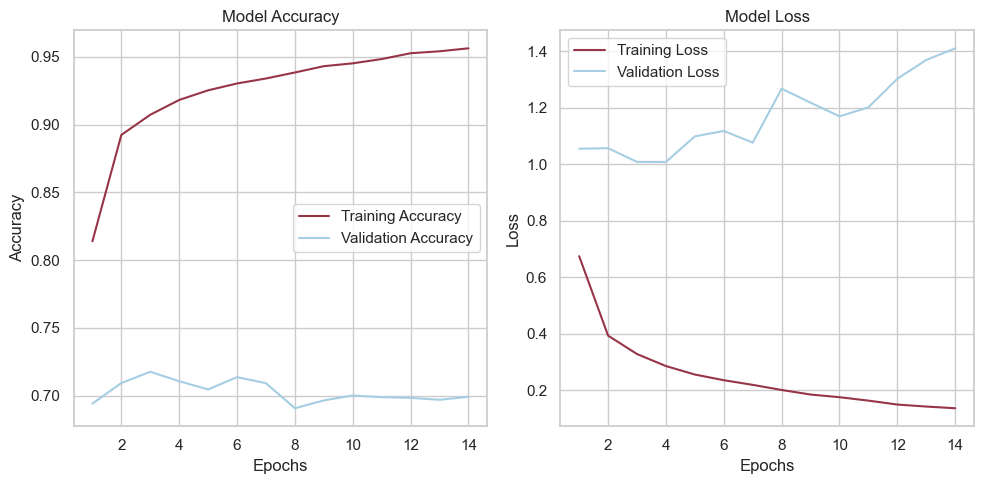

In [64]:
# # This looks like it is not an optimal approach
# Averaged accuracy and loss
avg_train_acc = np.mean([h['accuracy'] for h in history_list], axis=0)
avg_val_acc = np.mean([h['val_accuracy'] for h in history_list], axis=0)
avg_train_loss = np.mean([h['loss'] for h in history_list], axis=0)
avg_val_loss = np.mean([h['val_loss'] for h in history_list], axis=0)

# Plot averaged accuracy and loss
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), avg_train_acc, label='Training Accuracy')
plt.plot(range(1, epochs + 1), avg_val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), avg_train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), avg_val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

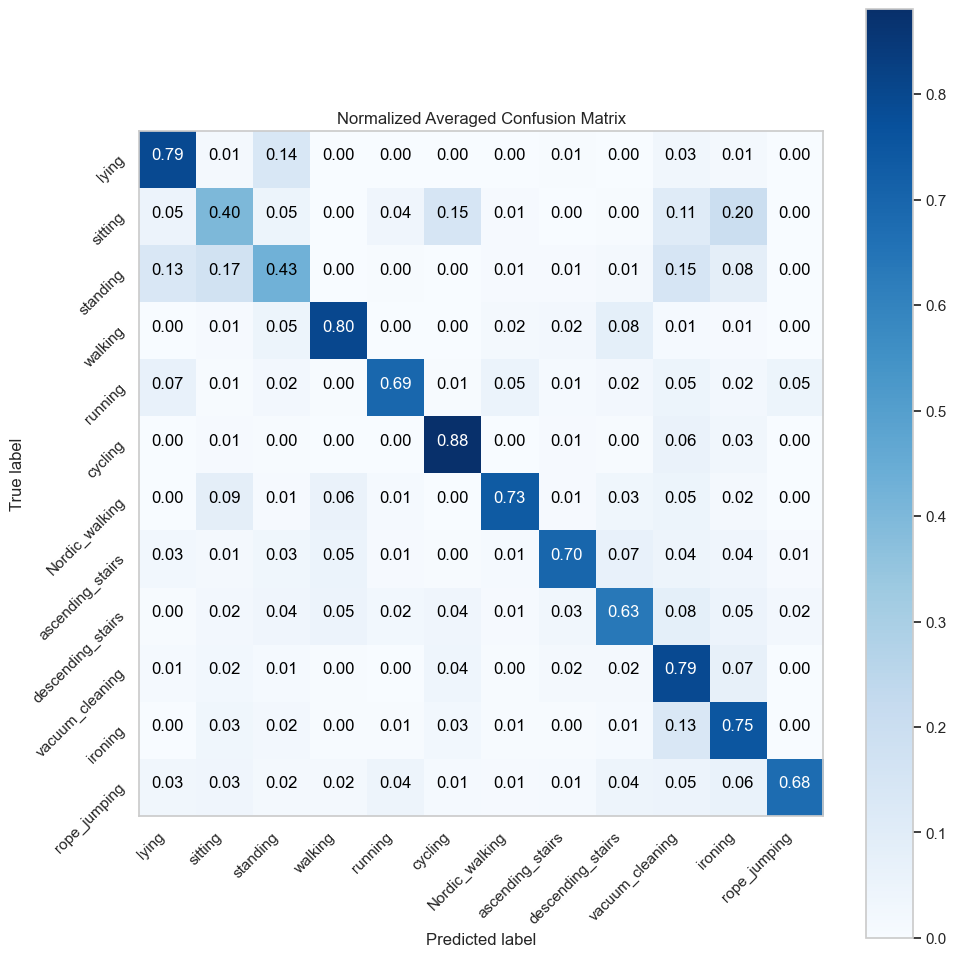

In [63]:
# Normalize the averaged confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0)
normalized_avg_cm = avg_cm / np.sum(avg_cm, axis=1)[:, np.newaxis]

# Create a list of labels for the unique_activities
labels = [activityID[i] for i in unique_activities]

# Plot normalized averaged confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(normalized_avg_cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Averaged Confusion Matrix')
plt.colorbar()

plt.grid(False)  # Remove grid lines

num_classes = len(labels)  # Number of unique activities

tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, labels, rotation=45, ha='right')  # Rotate x-axis labels by 45 degrees
plt.yticks(tick_marks, labels, rotation=45, va='baseline', ha='right', rotation_mode='anchor')  # Rotate y-axis labels by 45 degrees

# Print normalised values in the confusion matrix
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(normalized_avg_cm[i, j], '.2f'), horizontalalignment="center", color="white" if normalized_avg_cm[i, j] > 0.5 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
    # Calculate average metrics across folds
avg_precision = np.mean([h.history['val_precision'][-1] for h in history_list])
avg_accuracy = np.mean([h.history['val_accuracy'][-1] for h in history_list])
avg_recall = np.mean([h.history['val_recall'][-1] for h in history_list])

# Calculate average F1-score
avg_f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)

# Print average metrics
print("Average Precision:", avg_precision)
print("Average Accuracy:", avg_accuracy)
print("Average F1-score:", avg_f1_score)
print("Average Recall:", avg_recall)


In [ ]:
from sklearn.model_selection import StratifiedKFold, GroupKFold

# Define the number of folds for stratified k-fold cross-validation
k = 5

# Step 1: Stratify based on activities
skf = StratifiedKFold(n_splits=k)

# Initialize stratified index lists
train_indices = []
val_indices = []

# Step 2: Within each activity stratum, further stratify based on subject labels
for train_index, val_index in skf.split(windows, activities):
    train_sub_windows, train_sub_activities = windows[train_index], activities[train_index]
    train_sub_subjects = subjects[train_index]
    val_sub_windows, val_sub_activities = windows[val_index], activities[val_index]
    val_sub_subjects = subjects[val_index]

    gkf = GroupKFold(n_splits=k)
    train_sub_indices = []
    val_sub_indices = []
    for train_sub_index, val_sub_index in gkf.split(train_sub_windows, train_sub_activities, train_sub_subjects):
        train_sub_indices.append(train_index[train_sub_index])
        val_sub_indices.append(train_index[val_sub_index])

    train_indices.append(np.concatenate(train_sub_indices))
    val_indices.append(np.concatenate(val_sub_indices))

# At this point, train_indices and val_indices are lists of arrays,
# where each array corresponds to the indices for one fold. You can
# now use these indices to perform the k-fold cross-validation.

# Use StratifiedKFold to stratify based on activity labels.
# This will ensure an even distribution of activities across folds.
# Within each activity stratum, further stratify based on subject labels
# using GroupKFold. This will ensure that the same subject doesn't appear
# in both the training and test sets in the same fold.


In [ ]:
import numpy as np
from sklearn.model_selection import GroupKFold

n_splits = 5
# Combine subject and activity arrays to create a single group identifier
groups = [f"{subject}_{activity}" for subject, activity in zip(subjects, activities)]

gkf = GroupKFold(n_splits=n_splits)

train_indices = []
val_indices = []

for train_index, val_index in gkf.split(windows, activities, groups):
    train_indices.append(train_index)
    val_indices.append(val_index)

# At this point, train_indices and val_indices are lists of arrays,
# where each array corresponds to the indices for one fold. You can
# now use these indices to perform the k-fold cross-validation.
# It will try to maintain an even distribution of subjects and activities
# across the training and validation sets for each fold.
# However, this method still has the same limitations as the previous method,
# so perfect balance might not be possible in some cases.

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Step 3: Stratify the data and apply k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = np.array(windows)
y_activity = np.array(activities)
y_subject = np.array(subjects)

for train_val_index, test_index in skf.split(X, y_activity):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_activity_train_val, y_activity_test = y_activity[train_val_index], y_activity[test_index]
    y_subject_train_val, y_subject_test = y_subject[train_val_index], y_subject[test_index]

    skf_inner = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for train_index, val_index in skf_inner.split(X_train_val, y_activity_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_activity_train, y_activity_val = y_activity_train_val[train_index], y_activity_train_val[val_index]
        y_subject_train, y_subject_val = y_subject_train_val[train_index], y_subject_train_val[val_index]


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



# Step 3: Stratify the data and apply k-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

X = np.array(windows)
y_activity = np.array(activities)
y_subject = np.array(subjects)

accuracies = []
losses = []

for train_val_index, test_index in tqdm(skf.split(X, y_activity), desc='Outer Loop'):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_activity_train_val, y_activity_test = y_activity[train_val_index], y_activity[test_index]
    y_subject_train_val, y_subject_test = y_subject[train_val_index], y_subject[test_index]

    skf_inner = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    for train_index, val_index in tqdm(skf_inner.split(X_train_val, y_activity_train_val), desc='Inner Loop', leave=False):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_activity_train, y_activity_val = y_activity_train_val[train_index], y_activity_train_val[val_index]
        y_subject_train, y_subject_val = y_subject_train_val[train_index], y_subject_train_val[val_index]

        # Step 4: Train an LSTM model
        input_shape = X_train.shape[1:]
        num_classes = len(np.unique(y_activity))

        model = Sequential()
        model.add(LSTM(128, input_shape=input_shape))
        model.add(Dense(num_classes, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X_train, y_activity_train, epochs=10, batch_size=32, validation_data=(X_val, y_activity_val))

        # Step 6: Evaluate the model on the testing set
        loss, accuracy = model.evaluate(X_test, y_activity_test)
        accuracies.append(accuracy)
        losses.append(loss)

        # Plot accuracy and loss graphs
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

# Step 7: Calculate average accuracy and loss
avg_accuracy = np.mean(accuracies)
avg_loss = np.mean(losses)

print(f"Average Testing Accuracy: {avg_accuracy}")
print(f"Average Testing Loss: {avg_loss}")


In [ ]:
# import pandas as pd

# # Assuming train_data and test_data are your training and testing DataFrames
# # Replace 'subjectID' and 'activityID' with the actual column names in your data

# # For training data
# train_grouped = train_data.groupby(['subjectID', 'activityID']).size().reset_index(name='count')
# print("Training data samples count:")
# print(train_grouped)

# # For testing data
# test_grouped = test_data.groupby(['subjectID', 'activityID']).size().reset_index(name='count')
# print("\nTesting data samples count:")
# print(test_grouped)


In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Filter the data for protocol activities
protocol_acts = [1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24]
sensor_data = sensor_data[sensor_data['activityID'].isin(protocol_acts)]

# Interpolate missing values
sensor_data = sensor_data.interpolate()

def create_windows(data, step_size, stride):
    windows = []
    for i in range(0, len(data) - step_size, stride):
        windows.append(data.iloc[i:i+step_size])
    return windows

step_size = 100
stride = 50

# Stratify the data based on subjectID
unique_subjects = sensor_data['subjectID'].unique()
subject_windows = []

for subject in tqdm(unique_subjects):
    subject_data = sensor_data[sensor_data['subjectID'] == subject]
    subject_data_windows = create_windows(subject_data, step_size, stride)
    subject_windows.extend(subject_data_windows)

In [ ]:
import pandas as pd

# Assuming train_data and test_data are your training and testing DataFrames
# Replace 'subjectID' and 'activityID' with the actual column names in your data

# For training data
train_grouped = train_data.groupby(['subjectID', 'activityID']).size().reset_index(name='count')
print("Training data samples count:")
print(train_grouped)

# For testing data
test_grouped = test_data.groupby(['subjectID', 'activityID']).size().reset_index(name='count')
print("\nTesting data samples count:")
print(test_grouped)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

# Prepare data for LSTM model
def prepare_data(windows):
    activity_mapping = {activity: idx for idx, activity in enumerate(protocol_acts)}
    x = [window.iloc[:, 3:].values.astype('float32') for window in windows]  # Drop subjectID and timestamp columns
    y = [activity_mapping[window.iloc[0]['activityID']] for window in windows]
    print(x)
    print(y)
    exit()
    return np.array(x), to_categorical(y, num_classes=len(protocol_acts))


X, y = prepare_data(subject_windows)

# Apply k-fold cross-validation
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape))
    model.add(Dense(len(protocol_acts), activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:

# # Train and validate the model
# train_accuracies = []
# train_losses = []
# val_accuracies = []
# val_losses = []
# max_epochs_reached = 0
#
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
#
# for train_index, val_index in tqdm(skf.split(X, np.argmax(y, axis=1)), total=k, desc="Training progress"):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#
#     model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
#
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping])
#
#     train_accuracies.append(history.history['accuracy'])
#     train_losses.append(history.history['loss'])
#     val_accuracies.append(history.history['val_accuracy'])
#     val_losses.append(history.history['val_loss'])
#
#     max_epochs_reached = max(max_epochs_reached, len(history.history['accuracy']))
#
# # Calculate average accuracy and loss
# avg_train_accuracy = np.mean(train_accuracies, axis=0)
# avg_train_loss = np.mean(train_losses, axis=0)
# avg_val_accuracy = np.mean(val_accuracies, axis=0)
# avg_val_loss = np.mean(val_losses, axis=0)


train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
epochs_per_fold = []

epochs = 30
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

for train_index, val_index in tqdm(skf.split(X, np.argmax(y, axis=1)), total=k, desc="Training progress"):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_lstm_model((X_train.shape[1], X_train.shape[2]))

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=32, callbacks=[early_stopping])

    train_accuracies.append(history.history['accuracy'])
    train_losses.append(history.history['loss'])
    val_accuracies.append(history.history['val_accuracy'])
    val_losses.append(history.history['val_loss'])
    epochs_per_fold.append(len(history.history['accuracy']))

# Calculate average accuracy and loss
avg_train_accuracy = np.sum([np.sum(acc) for acc in train_accuracies]) / np.sum(epochs_per_fold)
avg_train_loss = np.sum([np.sum(loss) for loss in train_losses]) / np.sum(epochs_per_fold)
avg_val_accuracy = np.sum([np.sum(acc) for acc in val_accuracies]) / np.sum(epochs_per_fold)
avg_val_loss = np.sum([np.sum(loss) for loss in val_losses]) / np.sum(epochs_per_fold)

# Print average accuracy and loss
print(f"Average train accuracy: {avg_train_accuracy}")
print(f"Average train loss: {avg_train_loss}")
print(f"Average validation accuracy: {avg_val_accuracy}")
print(f"Average validation loss: {avg_val_loss}")


In [ ]:

# # Train and validate the model
# accuracies = []
# losses = []
#
# for train_index, val_index in tqdm(skf.split(X, np.argmax(y, axis=1)), total=k, desc="Training progress"):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]
#
#     model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
#
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)
#
#     accuracies.append(history.history['val_accuracy'])
#     losses.append(history.history['val_loss'])
#
# # Calculate average accuracy and loss
# avg_accuracy = np.mean(accuracies, axis=0)
# avg_loss = np.mean(losses, axis=0)
#
# print(avg_accuracy)
# print(avg_loss)
#
# # Plot ROC curve for accuracy and loss
# def plot_roc_curve(avg_accuracy, avg_loss):
#     plt.figure(figsize=(10, 5))
#
#     # Plot accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(avg_accuracy, label='Validation')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#
#     # Plot loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Validation')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#
#     plt.show()
#
# plot_roc_curve(avg_accuracy, avg_loss)

In [ ]:
# # Plot ROC curve for accuracy and loss
# def plot_roc_curve(history):
#     plt.figure(figsize=(10, 5))
#
#     # Plot accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history.history['accuracy'], label='Train')
#     plt.plot(history.history['val_accuracy'], label='Validation')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='lower right')
#
#     # Plot loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Validation')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend(loc='upper right')
#
#     plt.show()
#
# plot_roc_curve(history)

In [ ]:
def plot_roc_curve(avg_train_accuracy, avg_train_loss, avg_val_accuracy, avg_val_loss):
    plt.figure(figsize=(10, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_accuracy, label='Train')
    plt.plot(avg_val_accuracy, label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Train')
    plt.plot(avg_val_loss, label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Plot the results
plot_roc_curve(avg_train_accuracy[:max_epochs_reached], avg_train_loss[:max_epochs_reached], avg_val_accuracy[:max_epochs_reached], avg_val_loss[:max_epochs_reached])

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the dataset into features and labels
X = sensor_data.drop(["activityID", "timestamp", "subjectID"], axis=1)
y = sensor_data["activityID"]

# Preprocess the data
scaler = StandardScaler()
X = scaler.fit_transform(X)
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=128, input_shape=(X.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(units=len(np.unique(y)), activation="softmax"))

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Define the number of folds for stratified k-fold cross-validation
k = 5

# Split the dataset into training and testing sets using stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=k, shuffle=True)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Reshape the data for input to the LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Train the LSTM model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_pred = model.predict_classes(X_test)
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)


Observe the removal of miss-classified activities and transient activities with ID zero: 929662 items
(1942871, 20)
There is only one misclassified instance for subject 104, where they were predicted to have performed the running activity. However, according to the activities performed document, subject 104 never performed this activity.

Create a dictionary that maps the original label to a new sequential label and then use the replace method of the sensor_data DataFrame to replace the original labels with the new sequential labels.

In [ ]:
class_counts = sensor_data['activityID'].value_counts().sort_index()
print(class_counts)

In [ ]:
# # Get the unique activity IDs from the data
unique_activities = sorted(sensor_data['activityID'].unique())

# Create a label mapping from activity IDs to integers
label_map = {activity_id: i for i, activity_id in enumerate(unique_activities)}

# Replace activity IDs with their integer labels
sensor_data['activityID'] = sensor_data['activityID'].apply(lambda x: label_map[x])

To print out the population of each class in the activityID column of the sensor_data dataframe, you can use the value_counts() method as follows:

In [ ]:
class_counts = sensor_data['activityID'].value_counts().sort_index()
print(class_counts)

Count the number of samples per subject-activity combination. You can use the groupby function in Pandas to group the data by both subjectID and activityID, and then use the size() function to count the number of samples in each group.
This will print the number of samples per subject-activity combination. You can check if any combination has less than two samples, which is causing the error. If you find such a combination, you can either remove it from the dataset or merge it with another similar combination to make sure there are at least two samples in each group.

In [ ]:
group_counts = sensor_data.groupby(['subjectID', 'activityID']).size()
print(group_counts)

In [ ]:
# # Preprocess the data
# X = sensor_data.drop(["timestamp", "activityID", "subjectID"], axis=1) # Ignore first 3 columns (timestamp, subjectID, activityID)
# y = sensor_data[["subjectID", "activityID"]].values
#
# # Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
#
# # Define the window size and stride
# window_size = 100
# stride = 50
#
# # Group the data by subject and activity ID
# grouped_data = sensor_data.groupby(['subjectID', 'activityID'], sort=False)
#
# # Apply a window function to each group
# def apply_window_function(group):
#     windows = []
#     for i in range(0, len(group)-window_size+1, stride):
#         window = group.iloc[i:i+window_size]
#         window_label = window['activityID'].mode()[0]  # Assign the majority class label to the window
#         window_subject = window['subjectID'].unique()[0]  # Assign the subject ID to the window
#         window = window.drop(['subjectID', 'activityID'], axis=1)  # Drop the subject ID and activity ID columns from the window data
#         window = np.asarray(window)  # Convert the window data to a numpy array
#         windows.append((window, window_label, window_subject))
#     return windows
#
# grouped_windows = grouped_data.apply(apply_window_function)
# windows = [window for group in grouped_windows for window in group]
#
# # Split the windows into train and test sets, stratifying across both subject and activity IDs
# X = [window[0] for window in windows]
# y = [window[1] for window in windows]
# subject_ids = [window[2] for window in windows]
# X_train, X_test, y_train, y_test, subject_ids_train, subject_ids_test = train_test_split(X, y, subject_ids, test_size=0.2, random_state=42, shuffle=True, stratify=[y, subject_ids])
#
# # Convert the train and test sets to pandas dataframes
# train_data = pd.DataFrame({'data': X_train, 'activityID': y_train, 'subjectID': subject_ids_train})
# test_data = pd.DataFrame({'data': X_test, 'activityID': y_test, 'subjectID': subject_ids_test})

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# pd.set_option('display.max_colwidth', None)
#
# # Define window size and stride
# window_size = 100
# stride = 50
#
# # Create a list of all possible windows
# windows = []
# for subject, activity in sensor_data.groupby(['subjectID', 'activityID']):
#     subject_id = subject[0]
#     activity_id = activity['activityID'].iloc[0]
#     data = activity.drop(['subjectID', 'activityID'], axis=1)
#     for i in range(0, len(data)-window_size+1, stride):
#         window = data.iloc[i:i+window_size, :]
#         #windows.append([window.values, subject_id, activity_id])
#
# # Convert the list of windows to a DataFrame
# window_data = pd.DataFrame(windows, columns=['data', 'subjectID', 'activityID'])
# print(window_data.head(1))

# # Shuffle the windows
# window_data = window_data.sample(frac=1, random_state=42).reset_index(drop=True)
#
# # Extract the data and labels from the DataFrame
# X = np.stack(window_data['data'].values)
# y_activity = window_data['activityID'].values
# y_subject = window_data['subjectID'].values
#
# # Split the data into train and test sets, stratifying across both subject and activity IDs
# grouped_data = window_data.groupby(['subjectID', 'activityID'], sort=False)
# grouped_data_str = grouped_data[['subjectID', 'activityID']].apply(lambda x: '_'.join(x.astype(str)), axis=1)
# train_subjects, test_subjects = train_test_split(grouped_data_str, test_size=0.2, random_state=42, shuffle=True, stratify=grouped_data_str)
# train_subjects = pd.DataFrame({'subjectID': train_subjects.str.split('_').str[0].values, 'activityID': train_subjects.str.split('_').str[1].values})
# test_subjects = pd.DataFrame({'subjectID': test_subjects.str.split('_').str[0].values, 'activityID': test_subjects.str.split('_').str[1].values})
#
# train_data = window_data.merge(train_subjects, on=['subjectID', 'activityID'])
# test_data = window_data.merge(test_subjects, on=['subjectID', 'activityID'])


In [ ]:
"""
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth', None)

# Define window size and stride
window_size = 100
stride = 50

features = ['mean', 'std', 'min', 'max', '25th', '50th', '75th']

feature_columns = []
for sensor in fields[2:]:
    for feature in features:
        feature_column = sensor + '_' + feature
        feature_columns.append(feature_column)

print(len(feature_columns))
feature_set = pd.DataFrame(columns=feature_columns)

feature_set.head()
"""

In [ ]:
# from statistics import mode
#
# # Create a list of all possible windows
# windows = []
# for subject, activity in tqdm(sensor_data.groupby(['subjectID', 'activityID'])):
#     subject_id = subject[0]
#     activity_id = mode(activity['activityID']) # Implement majority voting
#     data = activity.drop(['subjectID', 'timestamp', 'activityID'], axis=1)
#
#     for i in range(0, len(data)-window_size+1, stride):
#         window = data.iloc[i:i+window_size, :]
#
#         # Extract features from the window
#         window_features = []
#         for col in range(window.shape[1]):
#             col_data = window.iloc[:, col].values
#             window_features.append(np.mean(col_data)) # mean
#             window_features.append(np.std(col_data)) # standard deviation
#             window_features.append(np.min(col_data)) # minimum
#             window_features.append(np.max(col_data)) # maximum
#             window_features.append(np.percentile(col_data, 25)) # 25th percentile
#             window_features.append(np.percentile(col_data, 50)) # 50th percentile
#             window_features.append(np.percentile(col_data, 75)) # 75th percentile
#
#         # Add the feature vector and label to the feature matrix and labels array
#         window_data = [subject_id, activity_id] + window_features
#         windows.append(window_data)
# print(windows[0])

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
#
# # normalise the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# normalised_data = scaler.fit_transform(sensor_data)
# normalised_data.tail(20)

## Windowing

In [ ]:
# Select the subset of columns for input data
data = sensor_data.iloc[:, 3:]

# Define window size and stride length
window_size = 100
stride_length = 50

# Create empty numpy arrays for input and output data
X = np.empty((0, window_size, data.shape[1]))
y = np.empty((0,))

# Loop through the data and create windows
for i in tqdm(range(0, len(data) - window_size, stride_length)):
    # Get the window and the corresponding label
    window = data.iloc[i:i+window_size, :]
    label = sensor_data.iloc[i+window_size]['activityID']

    # Append the window and label to the input and output data arrays
    X = np.append(X, [window.values], axis=0)
    y = np.append(y, [label], axis=0)

# Reshape the input data to have dimensions (num_windows, window_size, num_features)
X = np.reshape(X, (X.shape[0], window_size, data.shape[1]))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define number of output classes and features from input shape
num_features = X.shape[2]
num_classes = len(np.unique(y))

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=(window_size, num_features)))
model.add(Dense(units=num_classes, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training

## Time Series Cross-Validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Define the number of splits for cross-validation
n_splits = 5

# Initialize time series cross-validation object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Loop over the splits
for i, (train_index, test_index) in enumerate(tscv.split(X)):

    # Get the training and test data for this split
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model on the training data
    # model.fit(X_train, y_train, verbose=1)
    histpry = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[early_stop], verbose=1)


    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for split {i+1}: {accuracy}")

In this code block, we use the TimeSeriesSplit function from scikit-learn to perform time series cross-validation. We define the number of folds using the n_splits parameter, and then use the split method to generate indices for the training and test sets for each fold. We then use these indices to extract the corresponding subsets of the input and target data, and train and evaluate the model on each fold separately.

## Sliding Window Cross-Validation

In [ ]:
# Define the window size and step size
window_size = 100
step_size = 50

# Loop over the windows
for i in range(0, len(X) - window_size, step_size):

    # Get the training and test data for this window
    X_train = X[i:i+window_size]
    y_train = y[i:i+window_size]
    X_test = X[i+window_size:i+window_size+step_size]
    y_test = y[i+window_size:i+window_size+step_size]

    # Train the model on the training data
    # model.fit(X_train, y_train, verbose=1)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, callbacks=[early_stop], verbose=1)


    # Evaluate the model on the test data
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for window starting at index {i}: {accuracy}")

In this code block, we perform sliding window cross-validation by generating a series of overlapping windows over the training and test data. We define the window size and step size using the window_size and step_size parameters, and then use a generate_windows function (not shown) to generate overlapping windows of input and target data. We then train the model on each window of the training data, and evaluate it on the corresponding window of the test data. The j variable is used to calculate the index of the corresponding test window for each training window.

## Evaluation

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Plotting

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import pandas as pd

# Define window size and stride
window_size = 100
stride = 50

# Create empty lists for windows and labels
X_windows = []
y_labels = []

# Loop over all windows and extract features
for subject, activity in tqdm(sensor_data.groupby(['subjectID', 'activityID'])):
    data = activity.drop(['subjectID', 'activityID'], axis=1)
    label = activity['activityID'].iloc[0]

    for i in range(0, len(data)-window_size+1, stride):
        window = data.iloc[i:i+window_size, :]
        X_windows.append(window.values.flatten())
        y_labels.append(label)

# Convert windows and labels to numpy arrays
X_windows = np.array(X_windows)
y_labels = np.array(y_labels)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X_windows[:, 3:] = scaler.fit_transform(X_windows[:, 3:])

# One-hot encode the labels
y_labels = to_categorical(y_labels)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Reshape X_train, X_test, and X_val to be 3D arrays with shape (n_samples, window_size, n_features)
X_train = np.reshape(X_train, (X_train.shape[0]//window_size, window_size, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0]//window_size, window_size, X_test.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0]//window_size, window_size, X_val.shape[1]))

# Define the model
model = Sequential()

# Add an LSTM layer with 64 units and input shape of (window_size, num_features)
model.add(LSTM(units=64, input_shape=(window_size, X_train.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a second LSTM layer with 32 units
model.add(LSTM(units=32))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a dense layer with 12 units (one for each activity class) and softmax activation function
model.add(Dense(units=12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, test accuracy: {accuracy}')
"""

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
import pandas as pd

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(sensor_data)

# Define window size and stride
window_size = 100
stride = 50

# Create empty lists for windows and labels
X_windows = []
y_labels = []

# Loop over all windows and extract features
for subject, activity in tqdm(sensor_data.groupby(['subjectID', 'activityID'])):
    data = activity.drop(['subjectID', 'activityID'], axis=1)
    label = activity['activityID'].iloc[0]

    for i in range(0, len(data)-window_size+1, stride):
        window = data.iloc[i:i+window_size, :]
        X_windows.append(window.values)
        y_labels.append(label)

# Convert windows and labels to numpy arrays
X_windows = np.array(X_windows)
y_labels = np.array(y_labels)

# One-hot encode the labels
y_labels = to_categorical(y_labels)

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_windows, y_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the model
model = Sequential()

# Add an LSTM layer with 64 units and input shape of (window_size, num_features)
model.add(LSTM(units=64, input_shape=(window_size, X_train.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a second LSTM layer with 32 units
model.add(LSTM(units=32))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a dense layer with 12 units (one for each activity class) and softmax activation function
model.add(Dense(units=12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, test accuracy: {accuracy}')


In [ ]:
"""
from statistics import mode

# Define window size and stride
window_size = 100
stride = 50

# Create an empty list for the windowed data
windowed_data_arr = []

# Loop over all windows and extract the data
for subject, activity in tqdm(sensor_data.groupby(['subjectID', 'activityID'])):
    subject_id = int(subject[0])
    activity_id = int(mode(activity['activityID'])) # Implement majority voting
    data = activity.drop(['subjectID', 'activityID'], axis=1)

    for i in range(0, len(data)-window_size+1, stride):
        window = data.iloc[i:i+window_size, :]
        windowed_data_arr.append((subject_id, activity_id, window.values))

# Convert the windowed data to a dataframe
windowed_data_df = pd.DataFrame(windowed_data_arr, columns=['subjectID', 'activityID', 'window'])
windowed_data_df.tail(20)
windowed_data_df.shape
"""

## Feature selection matrix


In [ ]:
"""
import matplotlib.pyplot as plt
import seaborn as sns

# Create a correlation matrix of the feature_set dataframe
corr_matrix = feature_set.drop(['activityID', 'subjectID'], axis=1).corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='Blues')
plt.title('Feature Selection Matrix')
plt.show()
"""

In [ ]:
"""
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Split the feature set and target variable
X = feature_set.drop(columns=['activityID'])
y = feature_set['activityID']

# Select the top 20 features based on mutual information
selector = SelectKBest(mutual_info_classif, k=20)
selector.fit_transform(X, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_features = X.columns[selected_indices]

# Create a new feature set with the selected features
selected_feature_set = feature_set[['activityID'] + list(selected_features)]
"""

In [ ]:
"""
import matplotlib.pyplot as plt
import seaborn as sns

# Create a correlation matrix of the feature_set dataframe
corr_matrix = selected_feature_set.drop(columns=['activityID']).corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='Blues')
plt.title('Feature Selection Matrix')
plt.show()
"""

## Testing on the full 126 extracted features from each window

In [ ]:
# # Drop subjectID and activityID columns
# X = feature_set.drop(['subjectID', 'activityID'], axis=1)
#
# # Get target variable (activityID)
# y = feature_set['activityID']
#
# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
#
# # Define the model
# model = Sequential()
#
# # Add an LSTM layer with 64 units and input shape of (window_size, num_features)
# model.add(LSTM(units=64, input_shape=(window_size, feature_set.shape[1]-2)))
#
# # Add a dropout layer to prevent overfitting
# model.add(Dropout(0.5))
#
# # Add a dense layer with 12 units (one for each activity class)
# model.add(Dense(units=12, activation='softmax'))
#
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
#
# # Drop subjectID and activityID columns
# X = feature_set.drop(['subjectID', 'activityID'], axis=1)
#
# # Get target variable (activityID)
# y = feature_set['activityID']
#
# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# # Define the model
# model = Sequential()
#
# # Add an LSTM layer with 64 units and input shape of (window_size, num_features)
# model.add(LSTM(units=64, input_shape=(window_size, feature_set.shape[1]-2)))
#
# # Add a dropout layer to prevent overfitting
# model.add(Dropout(0.5))
#
# # Add a dense layer with 12 units (one for each activity class)
# model.add(Dense(units=12, activation='softmax'))
#
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
# # Fit the model
# model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
#
# # Make predictions on test data
# y_pred = model.predict(X_test)
#
# # Convert probabilities to class labels
# y_pred = np.argmax(y_pred, axis=1)

https://stackoverflow.com/questions/74917051/tensorflow-error-on-macbook-m1-pro-notfounderror-graph-execution-error
conda install -c apple tensorflow-deps=2.9.0
python -m pip install tensorflow-macos==2.9
pip install tensorflow-deps==2.9.0
pip install tensorflow-metal==0.5.0


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Drop subjectID and activityID columns
X = windowed_data_df.drop(['subjectID', 'activityID'], axis=1)

# Get target variable (activityID)
y = windowed_data_df['activityID']

# Split into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape data into 3D format
X_train = X_train.to_numpy().reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.to_numpy().reshape((X_test.shape[0], 1, X_test.shape[1]))
X_val = X_val.to_numpy().reshape((X_val.shape[0], 1, X_val.shape[1]))

# Define the model
model = Sequential()

# Add an LSTM layer with 64 units and input shape of (num_features,)
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a second LSTM layer with 32 units
model.add(LSTM(units=32))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a dense layer with 12 units (one for each activity class) and softmax activation function
model.add(Dense(units=12, activation='softmax'))

# One-hot encode the target variable
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, test accuracy: {accuracy}')

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Drop subjectID and activityID columns
X = windowed_data_df.drop(['subjectID', 'activityID'], axis=1)

# Get target variable (activityID)
y = windowed_data_df['activityID']

# One-hot encode the target variable
y = to_categorical(y)

# Split into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Reshape training data into 3D format
X_train = np.reshape(X_train.to_numpy(), (X_train.shape[0], 1, X_train.shape[1]))

# Reshape validation data into 3D format
X_val = np.reshape(X_val.to_numpy(), (X_val.shape[0], 1, X_val.shape[1]))

# Reshape testing data into 3D format
X_test = np.reshape(X_test.to_numpy(), (X_test.shape[0], 1, X_test.shape[1]))

# Define the model
model = Sequential()

# Add an LSTM layer with 64 units and input shape of (num_features,)
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a second LSTM layer with 32 units
model.add(LSTM(units=32))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.5))

# Add a dense layer with 12 units (one for each activity class) and softmax activation function
model.add(Dense(units=12, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {loss}, test accuracy: {accuracy}')


In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
#
# # Drop subjectID and activityID columns
# X = feature_set.drop(['subjectID', 'activityID'], axis=1)
#
# # Get target variable (activityID)
# y = feature_set['activityID']
#
# # Split into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
# # Define the model
# model = Sequential()
#
# # Add an LSTM layer with 64 units and input shape of (num_features,)
# model.add(LSTM(units=64, input_shape=(X_train.shape[1],)))
#
# # Add a dropout layer to prevent overfitting
# model.add(Dropout(0.5))
#
# # Add a dense layer with 12 units (one for each activity class)
# model.add(Dense(units=12, activation='softmax'))
#
# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#
# # Fit the model
# model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)
#
# # Make predictions on test data
# y_pred = model.predict(X_test)
#
# # Convert probabilities to class labels
# y_pred = np.argmax(y_pred, axis=1)


In [ ]:
from sklearn.metrics import classification_report

# Make predictions on test data
y_pred = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)

# Print classification report
target_names = ['class {}'.format(i) for i in range(12)]
print(classification_report(y_test, y_pred, target_names=target_names))


In [ ]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm
# from sklearn.model_selection import train_test_split
# pd.set_option('display.max_colwidth', None)
#
# # Define window size and stride
# window_size = 100
# stride = 50
#
# # Create a list of all possible windows
# feature_set = pd.DataFrame()
# for subject, activity in tqdm(sensor_data.groupby(['subjectID', 'activityID'])):
#     subject_id = subject[0]
#     activity_id = activity['activityID'].iloc[0] # Implement majority voting
#     data = activity.drop(['subjectID', 'timestamp', 'activityID'], axis=1)
#     for i in range(0, len(data)-window_size+1, stride):
#         window = data.iloc[i:i+window_size, :]
#
#         # Extract features from the window
#         window_features = []
#         for col in range(window.shape[1]):
#             col_data = window.iloc[:, col].values
#             window_features.append(np.mean(col_data)) # mean
#             window_features.append(np.std(col_data)) # standard deviation
#             window_features.append(np.min(col_data)) # minimum
#             window_features.append(np.max(col_data)) # maximum
#             window_features.append(np.percentile(col_data, 25)) # 25th percentile
#             window_features.append(np.percentile(col_data, 50)) # 50th percentile
#             window_features.append(np.percentile(col_data, 75)) # 75th percentile
#
#         # Add the feature vector and label to the feature matrix and labels array
#         window_data = [subject_id, activity_id] + window_features
#         windows.append(window_data)
# print(windows[0])

In [ ]:
# print(len(windows[0]))
# print(len(windows))
# print(len(sensor_data))

In [ ]:
import matplotlib.pyplot as plt

# Filter data for subjectID = 1 and protocol activities only
subject_data = sensor_data[(sensor_data['subjectID'] == 1) & (sensor_data['activityID'].isin(protocol_acts))]

# Group data by activityID
grouped_data = subject_data.groupby('activityID')

# Set up plot
fig, ax = plt.subplots()

# Define colors and labels for each activityID
colours = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan', 10: 'magenta', 11: 'yellow'}
labels = {0: 'lying', 1: 'sitting', 2: 'standing', 3: 'walking', 4: 'running', 5: 'cycling', 6: 'Nordic walking', 7: 'ascending stairs', 8: 'descending stairs', 9: 'vacuum cleaning', 10: 'ironing', 11: 'rope jumping'}

# Loop through each activityID and plot corresponding data
activity_id = []
x_means = []
y_means = []
z_means = []
for window_data in windows:
    if window_data[0] == 1: # if subject id is 1
        activity_id.append(window_data[1])
        x_means.append(window_data[79]) # mean for chestGyro1 x dimension
        y_means.append(window_data[86]) # mean for chestGyro2 y dimension
        z_means.append(window_data[93]) # mean for chestGyro3 z dimension
print(activity_id)
print(x_means)
print(y_means)
print(z_means)

# Create scatter plot with colored points
for i in range(len(activity_id)):
    ax.scatter(x_means[i], y_means[i], color=colours[activity_id[i]])

# Add axis labels and title
ax.set_xlabel('Mean Chest Gyro1 X Dimension')
ax.set_ylabel('Mean Chest Gyro2 Y Dimension')
ax.set_title('Activity Clustering for Subject 1')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Filter data for subjectID = 1 and protocol activities only
subject_data = sensor_data[(sensor_data['subjectID'] == 1) & (sensor_data['activityID'].isin(protocol_acts))]

# Group data by activityID
grouped_data = subject_data.groupby('activityID')

# Define colors and labels for each activityID
colours = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'brown', 6: 'pink', 7: 'gray', 8: 'olive', 9: 'cyan', 10: 'magenta', 11: 'yellow'}
labels = {0: 'lying', 1: 'sitting', 2: 'standing', 3: 'walking', 4: 'running', 5: 'cycling', 6: 'Nordic walking', 7: 'ascending stairs', 8: 'descending stairs', 9: 'vacuum cleaning', 10: 'ironing', 11: 'rope jumping'}

# Initialize 3D plot
fig = plt.figure(figsize=(8, 8))

# Initialize subplot
ax = fig.add_subplot(111, projection='3d')

# Set subplot size and position
fig.subplots_adjust(left=0.05, right=1, bottom=0.05, top=0.95)

# Loop through each activityID and plot corresponding data
activity_id, x_means, y_means, z_means = [], [], [], []
for window_data in windows:
    if window_data[0] == 1: # if subject id is 1
        activity_id.append(window_data[1])
        x_means.append(window_data[79]) # mean for chestGyro1 x dimension
        y_means.append(window_data[86]) # mean for chestGyro2 y dimension
        z_means.append(window_data[93]) # mean for chestGyro3 z dimension

# Create scatter plot with colored points and legend labels
for i in range(len(activity_id)):
    ax.scatter(x_means[i], y_means[i], z_means[i], color=colours[activity_id[i]])

# Add axis labels and title
ax.set_xlabel('Mean Chest Gyro1 X Dimension')
ax.set_ylabel('Mean Chest Gyro2 Y Dimension')
ax.set_zlabel('Mean Chest Gyro3 Z Dimension', labelpad=15)
ax.set_title('Activity Clustering for Subject 1')

plt.show()

Visualise the stratified test train split by plotting the distribution of both the target variable activityID and subjectID in each set.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Preprocess the data
# X = sensor_data.drop(["timestamp", "activityID"], axis=1) # Ignore columns timestamp and activityID
X = sensor_data
y = sensor_data["activityID"].values
stratify_by = sensor_data[["subjectID", "activityID"]].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify_by)

In [ ]:
# Plot the distribution of activityID in the train and test sets
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(x=y_train, ax=ax[0])
ax[0].set_title("Distribution of activityID in Train set")
sns.countplot(x=y_test, ax=ax[1])
ax[1].set_title("Distribution of activityID in Test set")
plt.show()

# Plot the distribution of subjectID in the train and test sets
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
sns.countplot(x=X_train["subjectID"], ax=ax[0])
ax[0].set_title("Distribution of subjectID in Train set")
sns.countplot(x=X_test["subjectID"], ax=ax[1])
ax[1].set_title("Distribution of subjectID in Test set")
plt.show()

In [ ]:
# Drop the subjectID column from X_train and X_test after we have stratified
X_train = X_train.drop("subjectID", axis=1)
X_test = X_test.drop("subjectID", axis=1)
# Also remove the column from the original feature set for later use
X = sensor_data.drop(["subjectID"], axis=1)

In [ ]:
X_train.head()

In [ ]:

# # Count the number of instances for each activity in the training set
# train_activity_counts = pd.Series(y_train).value_counts()
#
# # Count the number of instances for each activity in the testing set
# test_activity_counts = pd.Series(y_test).value_counts()
#
# # Plot the activity counts for the training set and testing set
# plt.subplot(1, 2, 1)
# plt.bar(train_activity_counts.index, train_activity_counts.values)
# plt.title("Training Set Activity Counts")
# plt.xlabel("Activity ID")
# plt.ylabel("Number of Instances")
#
# plt.subplot(1, 2, 2)
# plt.bar(test_activity_counts.index, test_activity_counts.values)
# plt.title("Testing Set Activity Counts")
# plt.xlabel("Activity ID")
# plt.ylabel("Number of Instances")
#
# plt.tight_layout()
# plt.show()


In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
#
# # Preprocess the data
# X = sensor_data.drop(["timestamp", "activityID", "subjectID"], axis=1) # Ignore first 3 columns (timestamp, subjectID, activityID)
# y_activity = sensor_data["activityID"].values
# y_subject = sensor_data["subjectID"].values
#
# # Split the data into training and testing sets
# from sklearn.model_selection import train_test_split
#
# X_train, X_test, y_activity_train, y_activity_test, y_subject_train, y_subject_test = train_test_split(X, y_activity, y_subject, test_size=0.2, random_state=42, stratify=y_activity)
#
# # Plot the count of activity IDs in the dataset
# plt.figure(figsize=(8,6))
# sns.countplot(x=y_activity)
# plt.title("Distribution of Activity IDs")
# plt.xlabel("Activity ID")
# plt.ylabel("Count")
# plt.show()
#
# # Plot the count of subject IDs in the dataset
# plt.figure(figsize=(8,6))
# sns.countplot(x=y_subject)
# plt.title("Distribution of Subject IDs")
# plt.xlabel("Subject ID")
# plt.ylabel("Count")
# plt.show()


In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:

# # Reshape the data for LSTM input
# n_timesteps, n_features = X.shape[0], X.shape[1]
# X_train = X_train.reshape((X_train.shape[0], n_timesteps, n_features))
# X_test = X_test.reshape((X_test.shape[0], n_timesteps, n_features))
#
# # Build the model
# model = tf.keras.Sequential()
# model.add(layers.LSTM(100, input_shape=(n_timesteps, n_features)))
# model.add(layers.Dense(100, activation='relu'))
# model.add(layers.Dense(y.shape[1], activation='softmax'))
#
# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#
# # Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)
#
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
# print(f"Test loss: {loss:.3f}")
# print(f"Test accuracy: {accuracy:.3f}")


In this code, we are dropping the `subject_id` and `activity_id` columns from the feature set `X`, and using the activity_id column as the label `y`. We then use the `train_test_split` function to split the data into train and test sets, with a test size of 0.2 and a random state of 42. We also use the `stratify` parameter to ensure that the train and test sets are stratified by both `subject_id` and `activity_id` whilst still preserving the order of timesteps within each window.

In [ ]:
# from sklearn.model_selection import train_test_split
#
# # Group the data by subject and activity ID
# grouped_data = sensor_data.groupby(['subjectID', 'activityID'], sort=False)
#
# # Split the data into train and test sets, stratifying across both subject and activity IDs
# train_subjects, test_subjects = train_test_split(grouped_data, test_size=0.2, random_state=42, shuffle=True, stratify=grouped_data[['subjectID', 'activityID']])
#
# # Concatenate the train and test sets back into single dataframes
# train_data = pd.concat([data for _, data in train_subjects], ignore_index=True)
# test_data = pd.concat([data for _, data in test_subjects], ignore_index=True)

In [ ]:
# from sklearn.model_selection import train_test_split
#
# # Split the data into training and testing sets with stratification
# train_data, test_data = train_test_split(sensor_data, stratify=(sensor_data['subjectID'], sensor_data['activityID']))


In [ ]:
# from sklearn.model_selection import train_test_split
#
# # Group the data by subject and activity ID
# grouped_data = sensor_data.groupby(['subjectID', 'activityID'], sort=False)
#
# # Split the data into train and test sets, stratifying across both subject and activity IDs
# train_subjects, test_subjects = train_test_split(grouped_data, test_size=0.2, random_state=42, shuffle=True, stratify=grouped_data[['subjectID', 'activityID']].apply(lambda x: x.str.cat(sep='_')))
#
# # Concatenate the train and test sets back into single dataframes
# train_data = pd.concat([data for _, data in train_subjects], ignore_index=True, sort=False)
# test_data = pd.concat([data for _, data in test_subjects], ignore_index=True, sort=False)

In [ ]:
# from sklearn.model_selection import train_test_split
#
# # Group the data by subject and activity ID
# grouped_data = sensor_data.groupby(['subjectID', 'activityID'], sort=False)
#
# # Split the data into train and test sets, stratifying across both subject and activity IDs
# train_subjects, test_subjects = train_test_split(
#     grouped_data, test_size=0.2, random_state=42, shuffle=True,
#     stratify=grouped_data[['subjectID', 'activityID']]
#         .apply(lambda x: '_'.join(x.astype(str)), axis=1))
#
# # Concatenate the train and test sets back into single dataframes
# train_data = pd.concat([data for _, data in train_subjects], ignore_index=True, sort=False)
# test_data = pd.concat([data for _, data in test_subjects], ignore_index=True, sort=False)


In [ ]:
# from sklearn.model_selection import train_test_split
#
# # Group the data by subject and activity ID
# grouped_data = sensor_data.groupby(['subjectID', 'activityID'], sort=False)
#
# # Concatenate the subjectID and activityID columns into a single column with '_' as separator
# def concat_columns(x):
#     return '_'.join(x.astype(str).values)
#
# grouped_data_str = grouped_data[['subjectID', 'activityID']].apply(concat_columns)
#
# # Split the data into train and test sets, stratifying across both subject and activity IDs
# train_subjects, test_subjects = train_test_split(grouped_data, test_size=0.2, random_state=42, shuffle=True, stratify=grouped_data_str)
#
# # Concatenate the train and test sets back into single dataframes
# train_data = pd.concat([data for _, data in train_subjects], ignore_index=True, sort=False)
# test_data = pd.concat([data for _, data in test_subjects], ignore_index=True, sort=False)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

# Set the number of folds
n_splits = 5

# Create a time series split object
tscv = TimeSeriesSplit(n_splits=n_splits)

# Iterate over the folds
for train_index, test_index in tscv.split(data):
    # Split the data into train and test sets
    train_data, test_data = data[train_index], data[test_index]

    # Train and test the model
    model.fit(train_data, train_labels, verbose=1)
    test_preds = model.predict(test_data)

    # Evaluate the model
    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Fold accuracy: {accuracy}")


In [ ]:
from keras.utils import to_categorical

def one_hot_encoding(sensor_data):
    """
    Maps non-sequential activity IDs to sequential IDs and converts labels to one-hot encoding.

    Args:
    sensor_data: A Pandas dataframe containing sensor data.

    Returns:
    A modified Pandas dataframe with activity IDs mapped to sequential IDs and labels converted to one-hot encoding.
    """
    label_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 12: 7, 13: 8, 16: 9, 17: 10, 24: 11}
    sensor_data['activityID'] = sensor_data['activityID'].map(label_map)

    num_classes = len(label_map)
    labels = sensor_data['activityID'].values
    sensor_data['activityID'] = to_categorical(labels, num_classes=num_classes)
    print()
    return sensor_data

def extract_features(sensor_data):
    """
    Extracts features from sensor data.

    Args:
    sensor_data: A Pandas dataframe containing sensor data.

    Returns:
    A tuple containing the feature matrix and labels array.
    """
    # Define window size and step size
    window_size = 100
    step_size = 50

    # Initialize an empty feature matrix and labels array
    features = []
    labels = []
    print(sensor_data.shape)
    # Slide the window over the data and extract features from each window
    for i in range(0, len(sensor_data) - window_size, step_size):
        # Extract the window of data
        window = sensor_data.iloc[i:i+window_size]

        # Extract the label of the window
        label = window['activityID'].values[0]

        # Check if the label is in the list of activities we want to classify
        if label in protocol_acts:
            # Check if the window contains only a single activity
            if len(window['activityID'].unique()) == 1:
                # Extract features from the window
                window_features = []
                for col in range(3, len(sensor_data.columns)): # exclude timestep, subjectID and activityID from feature extraction
                    col_data = window.iloc[:, col].values
                    window_features.append(np.mean(col_data))
                    window_features.append(np.std(col_data))
                    window_features.append(np.min(col_data))
                    window_features.append(np.max(col_data))
                    window_features.append(np.percentile(col_data, 25))
                    window_features.append(np.percentile(col_data, 50))
                    window_features.append(np.percentile(col_data, 75))

                # Add the feature vector and label to the feature matrix and labels array
                features.append(window_features)
                labels.append(label)

    # Convert the feature matrix and labels array to numpy arrays
    features = np.array(features)
    labels = np.array(labels)

    return features, labels

sensor_data = one_hot_encoding(sensor_data)
features, labels = extract_features(sensor_data)

In [ ]:
"""
windows without regard to true label
classify by majority of activity performed
cross validation
apply rotation matrix to windows after classifying each
"""

In [ ]:
print('Features\n')
print(features)
print('\nLabels\n')
print(labels)
print(features.shape)
print(len(labels))

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Define the input shape
num_classes = len(set(labels))
n_timesteps, n_features = X_train.shape[0], X_train.shape[1]

# Reshape the input data
X_train = np.reshape(X_train, (X_train.shape[0], n_timesteps, n_features))
X_test = np.reshape(X_test, (X_test.shape[0], n_timesteps, n_features))

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(n_timesteps, n_features)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)

# Test the model
score, accuracy = model.evaluate(X_test, y_test, batch_size=64)
print('Test loss:', score)
print('Test accuracy:', accuracy)

In [ ]:
    from sklearn.metrics import classification_report

In [ ]:
# from tensorflow.keras.utils import to_categorical
#
# # Convert the activity labels to one-hot vectors
# labels_train_onehot = to_categorical(labels_train - 1, num_classes=num_activities)
# labels_test_onehot = to_categorical(labels_test - 1, num_classes=num_activities)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# Create the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(len(protocol_acts), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', test_acc)

In [ ]:

num_activities = 12
window_size = 100
num_features = 7
# Define the input shape
input_shape = (window_size, num_features)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=64, input_shape=input_shape))
model.add(Dropout(0.5))
model.add(Dense(units=num_activities, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(features_train, labels_train, epochs=10, batch_size=32, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(features_test, labels_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert the activity labels to one-hot vectors
labels_train_onehot = to_categorical(labels_train - 1, num_classes=num_activities)
labels_test_onehot = to_categorical(labels_test - 1, num_classes=num_activities)

In [ ]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense
#
# # Define the LSTM model
# model = Sequential()
# model.add(LSTM(64, input_shape=(window_size, num_features)))
# model.add(Dense(num_classes, activation='softmax'))
#
# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# # Train the model
# model.fit(train_features, train_labels, epochs=10, batch_size=32, verbose=1)

In [ ]:
# # Evaluate the model on the testing set
# loss, accuracy = model.evaluate(test_features, test_labels)
#
# # Print the testing set accuracy
# print('Testing set accuracy: {:.2f}%'.format(accuracy * 100))

In [ ]:
# timestamp = df[0]
# activity_id = df[1]
# heart_rate = df[2]  # unlikely to be used
#
# imu_hand_temp = df.iloc[3] # unlikely to be used
# imu_hand_acc_x = df.iloc[4]
# imu_hand_acc_y = df.iloc[5]
# imu_hand_acc_z = df.iloc[6]
# imu_hand_gyro_x = df.iloc[10]
# imu_hand_gyro_y = df.iloc[11]
# imu_hand_gyro_z = df.iloc[12]
#
# imu_chest_temp = df.iloc[20] # unlikely to be used
# imu_chest_acc_x = df.iloc[21]
# imu_chest_acc_y = df.iloc[22]
# imu_chest_acc_z = df.iloc[23]
# imu_chest_gyro_x = df.iloc[27]
# imu_chest_gyro_y = df.iloc[28]
# imu_chest_gyro_z = df.iloc[29]
#
# imu_ankle_temp = df.iloc[37] # unlikely to be used
# imu_ankle_acc_x = df.iloc[48]
# imu_ankle_acc_y = df.iloc[39]
# imu_ankle_acc_z = df.iloc[40]
# imu_ankle_gyro_x = df.iloc[44]
# imu_ankle_gyro_y = df.iloc[45]
# imu_ankle_gyro_z = df.iloc[46]

There are many higher-order features that can be computed. Some examples are:

1. Time-domain features: These include mean, standard deviation, skewness, kurtosis, minimum, maximum, range, and interquartile range of the raw sensor data.
2. Frequency-domain features: These include power spectral density, fast Fourier transform, and wavelet transform of the raw sensor data.
Statistical features: These include mean crossing rate, autocorrelation, and cross-correlation of the raw sensor data.
3. Signal quality features: These include signal-to-noise ratio, signal-to-artifact ratio, and signal-to-interference ratio of the raw sensor data.
4. Heart rate variability: Such as time-domain, frequency-domain, and non-linear HRV features.
5. Gait-related features: Such as step length, step width, step time, and stride time can be calculated for walking and running activity.
6. Others: Some other examples include the calculation of entropy, fractal dimension, and information-theoretic features of the sensor data.

It's important to note that feature extraction is a crucial step in the machine learning pipeline and the choice of features can greatly impact the model's performance. It's recommended to perform some feature selection or feature engineering to select the most relevant features for the task at hand.

### Here's a sample code to perform windowing and feature extraction on a pandas dataframe:

In [ ]:
import pandas as pd
import numpy as np

# Sample dataframe
df = pd.DataFrame({
    'subject_id': [1, 1, 1, 1, 1],
    'activityID': [0, 0, 0, 0, 0],
    'handAcc16_1': [2.37223, 2.18837, 2.37357, 2.07473, 2.22936],
    'handAcc16_2': [8.60074, 8.5656, 8.60107, 8.52853, 8.83122],
    'handAcc16_3': [3.51048, 3.66179, 3.54898, 3.66021, 3.7],
    'handGyro1': [-0.0922174, -0.0244132, -0.0579761, -0.0023516, 0.0122691],
    'handGyro2': [0.0568115, 0.0477585, 0.0325743, 0.0328098, 0.018305],
    'handGyro3': [-0.0158445, 0.00647434, -0.00698815, -0.00374727, -0.0533248],
    'chestAcc16_1': [0.23808, 0.31953, 0.235593, 0.388697, 0.3158],
    'chestAcc16_2': [9.80003, 9.61282, 9.72421, 9.53572, 9.49908],
    'chestAcc16_3': [-1.68896, -1.49328, -1.76621, -1.7241, -1.60914],
    'chestGyro1': [-0.00506495, 0.013685, -0.0399232, 0.00751315, -0.00382244],
    'chestGyro2': [-0.00678097, 0.00148646, 0.0340559, -0.0104983, -0.0112166],
    'chestGyro3': [-0.00566295, -0.0415218, -0.002113, -0.020684, -0.0259745],
    'ankleAcc16_1': [9.65918, 9.6937, 9.58944, 9.58814, 9.69771],
    'ankleAcc16_2': [-1.65569, -1.57902, -1.73276, -1.7704, -1.65625],
    'ankleAcc16_3': [-0.0997967, -0.215687, 0.0929141, 0.0545449, -0.0608086],
    'ankleGyro1': [0.00830026, -0.00657665, 0.00301426, 0.00317498, 0.0126977],
    'ankleGyro2': [0.00925038, -0.00463778, 0.000148236, -0.0203009, -0.0143027],
    'ankleGyro3': [0.00925038, -0.00463778, 0.000148236, -0.0203009, -0.0143027]})

def windowing_and_feature_extraction(df, window_size, overlap_ratio):
    features = []
    windows = []
    n = df.shape[0]
    shift = int(window_size * (1 - overlap_ratio))
    for i in range(0, n - window_size + 1, shift):
        window = df.iloc[i:i+window_size]
        print(window)
        windows.append(window)
        mean = np.mean(window, axis=0)
        std = np.std(window, axis=0)
        min = np.min(window, axis=0)
        max = np.max(window, axis=0)
        features.append(np.concatenate([mean, std, min, max]))
    return windows, np.array(features)

# example usage
windows, features = windowing_and_feature_extraction(df, window_size=100, overlap_ratio=0.5)

Note: The windowing_and_feature_extraction function takes three inputs:

df: the original dataframe
window_size: the size of the window to extract from the data
overlap_ratio: the ratio of overlap between consecutive windows, expressed as a fraction between 0 and 1
The function returns two outputs:

windows: a list of sub-dataframes, each representing a window of the original data
features: a 2D numpy array of shape (number of windows, number of features), where each row represents the extracted features from a window of the original data

In [ ]:
print(windows)
print(features)